In [112]:
import warnings

warnings.filterwarnings('ignore', message= 'Series.__getitem__')
warnings.filterwarnings('ignore', category = DeprecationWarning)
import numpy as np
import pandas as pd
no_deprecation_warning=True
df = pd.read_csv('dataset_topics_60k.csv')
df.dtypes

Unnamed: 0            int64
0                    object
1                    object
2                    object
source               object
hash                 object
topic1              float64
topic2              float64
topic3              float64
topic4              float64
topic5              float64
topic6              float64
topic7              float64
topic8              float64
topic9              float64
topic10             float64
topic11             float64
topic12             float64
topic13             float64
topic14             float64
topic15             float64
best topic           object
best probability    float64
dtype: object

In [98]:
# Function to create a string instance based on specific columns in a DataFrame
def combine_columns_to_string(index):
    # Ensuring the index is non-negative
    assert index >= 0, 'Index cannot be a negative integer'

    # Retrieving the row at the specified index
    selected_row = df.iloc[index, :]

    # Combining columns 0, 1, and 2 into a single string
    # making the poem seem together at similar manner
    combined_string = str(selected_row[1]) +' ' +str(selected_row[2]) + ' '+str(selected_row[3])

    return combined_string

# Applying the function to each row in the df
document = [combine_columns_to_string(i) for i in range(len(df.iloc[:, 2]))]
print(len(document))
document[:10]

26327


["visiting the graves stronger the october wind at my grandparents'",
 'profound blue of night  the resin and salt of pines so far from the sea',
 'scattered in the ditch  like tiny scraps of blue sky bits of plastic bag',
 'the smell of her hands on the neck of the bottle drinking greedily',
 "christmas services a cellular phone rings out handel's messiah",
 "gazing at the moon on a still summer's evening feast for mosquitoes",
 'my tea gets colder and the madeleine just sinks memory betrays',
 'small green waves crashing against a porcelain rim morning tea tempest',
 'red poppies growing between rows of white tombstones as in remembrance',
 'in front of bronze doors they huddle against the cold the newly homeless']

In [99]:
#cleaning the document
document = [string.replace('\'', '') for string in document]
document[:5]

['visiting the graves stronger the october wind at my grandparents',
 'profound blue of night  the resin and salt of pines so far from the sea',
 'scattered in the ditch  like tiny scraps of blue sky bits of plastic bag',
 'the smell of her hands on the neck of the bottle drinking greedily',
 'christmas services a cellular phone rings out handels messiah']

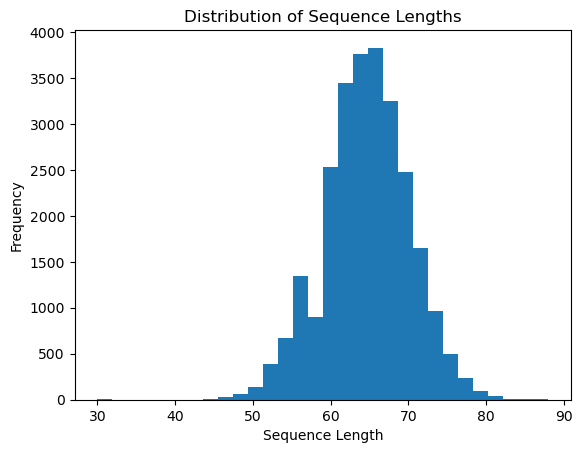

In [100]:
import matplotlib.pyplot as plt

# For sequence lengths, assuming 'text' column contains sequences
sequence_lengths = [len(seq) for seq in document]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [101]:
import random
import os

# time related modules
import time
import datetime
import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler


In [102]:
RAND_SEED = 73
BATCH_SIZE = 2
EPOCHS = 1
MAX_LEN = 60

In [103]:
class PoemDataset(Dataset):
    """
    Custom Dataset subclass.
    The dataset reads a list of strings (data), tokenizes them using a pre-specified tokenizer, and returns
    their corresponding input_ids and attention_masks as tensors.
    
    :param data: List of strings to tokenize.
    :param tokenizer: Tokenizer object to be used to tokenize data.
    :param gpt2_type: (Optional) Type of GPT-2 used.
    :param max_length: (Optional) Maximum length of the sequences.
    """
    def __init__(self, data, tokenizer, gpt2_type='gpt2', max_length=MAX_LEN):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        # Iterate over data, tokenize each sequence and append its input_id and attention_mask to respective lists
        for i in data:
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length')

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        """
        Returns the number of sequences in data.
        
        :return: number of sequences in data
        """
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        """
        Returns the input_id and attention_mask tensors of the sequence at the provided index.
        
        :param idx: index to access
        :return: tensors of input_id and attention_mask of the sequence at the provided index.
        """
        return self.input_ids[idx], self.attn_masks[idx]

In [104]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens_dict = {
    'bos_token': '<BOS>', 
    'eos_token': '<EOS>', 
    'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

In [105]:
poem_dataset = PoemDataset(document, tokenizer, max_length=MAX_LEN)
poem_dataset

In [106]:
def train_val_split(split, dataset):
    # calculate the size of the training dataset
    train_size = int(split * len(dataset)) 
    # the remaining data will be used for validation
    val_size = len(dataset) - train_size    
    return train_size, val_size


poem_train_size, poem_val_size = train_val_split(0.8, poem_dataset)

poem_train_dataset, poem_val_dataset = random_split(poem_dataset,[poem_train_size, poem_val_size])

In [107]:
poem_train_dataset, poem_val_dataset

(<torch.utils.data.dataset.Subset at 0x1fb09ec8fd0>,
 <torch.utils.data.dataset.Subset at 0x1fa624f4450>)

In [108]:
torch.cuda.manual_seed_all(RAND_SEED)
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)

In [109]:
poem_train_dataloader = DataLoader(poem_train_dataset,
                              sampler=RandomSampler(poem_train_dataset),
                              batch_size=BATCH_SIZE)

poem_val_dataloader = DataLoader(poem_val_dataset,
                            sampler=SequentialSampler(poem_val_dataset),
                            batch_size=BATCH_SIZE)

In [110]:
# helper function for logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-3
eps = 1e-8
warmup_steps = 50
device = torch.device('cuda')

In [113]:
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained('gpt2', output_hidden_states=True)
model = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration)
model.resize_token_embeddings(len(tokenizer))
model.cuda()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)
total_steps = len(poem_train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)


# Move the model to the specific device (GPU/CPU).
model = model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50260. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
C:\Users\OMEN\anaconda3\envs\fastaging\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [92]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50260, bias=False)
)

In [70]:
len(poem_train_dataloader)

10531

In [71]:
# Initialize an empty list to hold the losses during training
losses = []
valid_losses =[]
start_time = time.time()

for epoch_i in range(0, EPOCHS):

    print(f'Epoch {epoch_i + 1} of {EPOCHS}')

    t0 = time.time()
    
    # Reset the total training loss for this epoch
    total_train_loss = 0

    model.train()

    # Loop over each batch from the training data loader
    for step, batch in enumerate(poem_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        # Clear out the gradients from the previous training step
        model.zero_grad()        

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        # Extract the loss from the outputs
        loss = outputs[0]  

        # Extract and accumulate the total loss
        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()

        optimizer.step()

        # Update the learning rate
        scheduler.step()

        losses.append(loss.item())
        

        if step % 50 == 0:
            print(f"Step: {step}, Loss: {loss.item():.4f}")

        # Break the loop after 1000 steps.

    # Calculate the average training loss for this epoch
    avg_train_loss = total_train_loss / len(poem_train_dataloader)       

    # Calculate the time spent on this epoch
    training_time = format_time(time.time() - t0)

    # Print the average training loss and time spent on this epoch
    print(f'Average Training Loss: {avg_train_loss}. Epoch Training Time: {training_time}')

    # Set the model to 'eval' mode. This is important when the model has layers like dropout, batchnorm etc. which behave differently during training and evaluation.
    model.eval()

    # Reset the total validation loss
    total_eval_loss = 0
    nb_eval_steps = 0

    # Loop over each batch from the validation data loader
    for batch in poem_val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        # We don't need to track gradients for validation, so wrap in no_grad to save memory
        with torch.no_grad():        

            # Forward pass
            outputs  = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]  

        # Accumulate the validation loss
        batch_loss = loss.item()
        total_eval_loss += batch_loss     
        valid_losses.append(batch_loss)   

    # Calculate the average validation loss for this epoch
    avg_val_loss = total_eval_loss / len(poem_val_dataloader)

    print(f'Average Validation Loss: {avg_val_loss}')

print(f'Total Training Time: {format_time(time.time()-start_time)}')

Epoch 1 of 1
Step: 0, Loss: 1.4802
Step: 50, Loss: 1.3811
Step: 100, Loss: 1.6934
Step: 150, Loss: 1.4487
Step: 200, Loss: 1.3658
Step: 250, Loss: 1.2143
Step: 300, Loss: 1.2418
Step: 350, Loss: 1.5410
Step: 400, Loss: 1.7481
Step: 450, Loss: 1.7697
Step: 500, Loss: 1.5320
Step: 550, Loss: 1.5114
Step: 600, Loss: 1.3150
Step: 650, Loss: 1.5479
Step: 700, Loss: 1.2838
Step: 750, Loss: 1.4298
Step: 800, Loss: 1.2181
Step: 850, Loss: 1.2481
Step: 900, Loss: 1.1354
Step: 950, Loss: 1.3602
Step: 1000, Loss: 1.6107
Step: 1050, Loss: 1.1027
Step: 1100, Loss: 1.3481
Step: 1150, Loss: 1.2878
Step: 1200, Loss: 1.2480
Step: 1250, Loss: 1.6056
Step: 1300, Loss: 1.2559
Step: 1350, Loss: 1.6447
Step: 1400, Loss: 1.2484
Step: 1450, Loss: 1.5100
Step: 1500, Loss: 1.5679
Step: 1550, Loss: 1.2634
Step: 1600, Loss: 1.5001
Step: 1650, Loss: 1.5291
Step: 1700, Loss: 1.0583
Step: 1750, Loss: 1.0319
Step: 1800, Loss: 1.3905
Step: 1850, Loss: 1.3478
Step: 1900, Loss: 1.2322
Step: 1950, Loss: 1.2376
Step: 2000

In [72]:
import matplotlib.pyplot as plt

In [79]:
len(losses)

10531

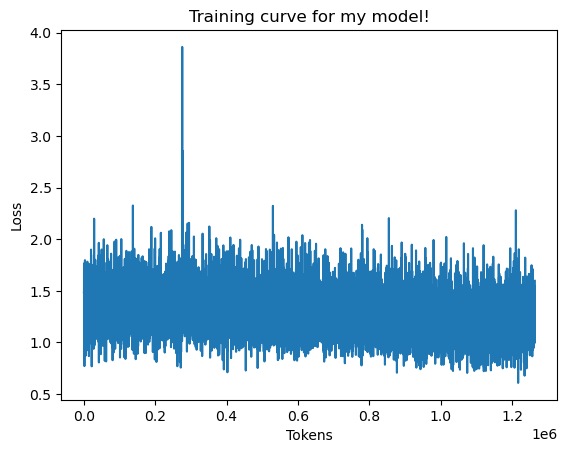

In [80]:
x = np.arange(len(losses)) * (MAX_LEN * BATCH_SIZE)

# Plot the line chart
plt.plot(x, losses)
plt.xlabel('Tokens')
plt.ylabel('Loss')
plt.title('Training curve for my model!')
plt.show()

## The loss at the beginning of the epoch is already low because it has been retrained again from previous run.

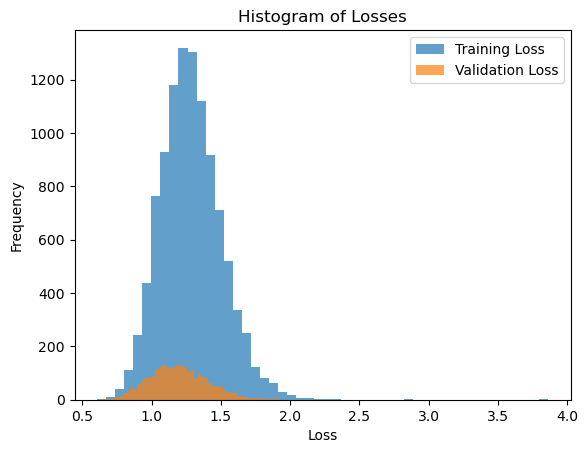

In [74]:
plt.hist(losses, bins=50, alpha=0.7, label='Training Loss')
plt.hist(valid_losses, bins=50, alpha=0.7, label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Losses')
plt.legend()
plt.show()

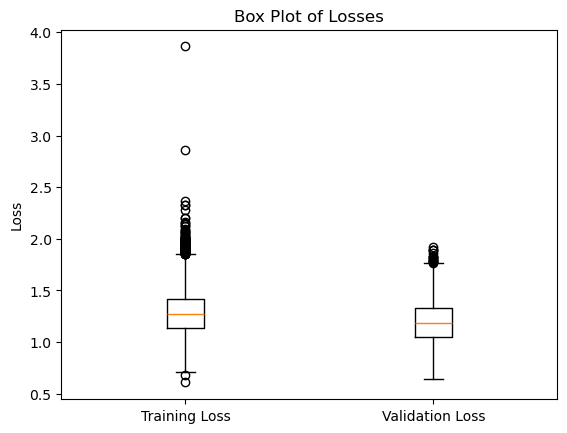

In [75]:
plt.boxplot([losses, valid_losses], labels=['Training Loss', 'Validation Loss'])
plt.ylabel('Loss')
plt.title('Box Plot of Losses')
plt.show()

In [76]:
train_avg_loss = total_train_loss / len(poem_train_dataloader.dataset)
train_perplexity = 2 ** train_avg_loss  # Perplexity formula: 2^average_loss_per_token

val_avg_loss = total_eval_loss / len(poem_val_dataloader.dataset)
val_perplexity = 2 ** val_avg_loss

print(f'Training Perplexity: {train_perplexity}')
print(f'Validation Perplexity: {val_perplexity}')

Training Perplexity: 1.5605445236557192
Validation Perplexity: 1.512593041600158


In [77]:
torch.save(model.state_dict(),  'gpt2_model.pth')

In [78]:
# text = "I love my dog"
# input_ids = tokenizer.encode(text, return_tensors='tf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# create text generation seed promp
prompts = ["<BOS> Blue sky, green","<BOS> Life with sadness","<BOS> Wild water apples"]
for prompt in prompts:
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length=MAX_LEN,
                                    top_p=0.95, 
                                    num_return_sequences=3
                                    )

    # print(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

    for i, sample_output in enumerate(sample_outputs):
        print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Blue sky, green blue autumn is a natural place in the sky


1: Blue sky, green light shimmering on winter night with sun stars flying away


2: Blue sky, green sky and white and blue sky the grey stars of winter sky




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Life with sadness  is like i dont like being able to get out


1: Life with sadness in  these days but well get the death to the truth


2: Life with sadness is nt always easy but i love it and love it


0: Wild water apples  make my own own heart more uncomfortable


1: Wild water apples is  better than silk apple apples is more than fruit


2: Wild water apples only  one thing the moon is snowing the cold


